# Rotation and spots

Two main features our software enables to implement are **rotation** and **spots** (of any feature).

In [1]:
from models import IcosphereModel
from models.mesh_transform import add_rotation, evaluate_rotation
from models.spots import add_spots
from plots import plot_3D, plot_3D_sequence
from spectrum import simulate_spectrum, blackbody_intensity
import astropy.units as u
import astropy.constants as const
import jax.numpy as jnp
import numpy as np
import matplotlib.pyplot as plt

from jax import config

# This is crucial so that flux is calculated with proper precision
config.update("jax_enable_x64", True)

## Model construction

We are going to use a simple Icosphere model. (Refer to the ```icosphere.ipynb``` notebook for more information)

The **parameters** in the Icosphere model are for the user to be defined. What's crucial is to ensure the compatibility with the desired **flux model**.

We are going to use a simple **blackbody model**.

### Functional design

All of our operations on meshes implement the functional design and don't modify the passed mesh (to ensure that everything can be used with JAX's ```jit```).
The ```add_spots``` function takes a simple mesh model and returns a copied mesh model with spots added.

In [2]:
# Some base and spot temperature in K
base_temp = 5700
spot_temp = 4000
spot_diff = spot_temp - base_temp

m = IcosphereModel.construct(1000, u.solRad.to(u.cm), u.solMass.to(u.kg), 1., jnp.concatenate([jnp.array([base_temp]), jnp.array([3.75])]))

# Theta and phi are the spot coordinates (in the radial coordinate system)
# Radius and radius factor define the size and cut-off of the spot
# The param index refers to which parameter is the difference applied to - parameters can be defined by the user. In our case, we are adding a temperature spot.
spotted_m = add_spots(mesh=m,
                      thetas=jnp.array([1.5]),
                      phis=jnp.array([0.]),
                      param_deltas=jnp.array([spot_diff]),
                      radii=jnp.array([.75]),
                      radius_factors=jnp.array([.75]),
                      param_indices=jnp.array([0]))

rotating_m = add_rotation(mesh=spotted_m,
                          rotation_velocity=100,
                          rotation_axis=jnp.array([0., 0., 1.]))

## Evaluation

After adding a dynamical information, like **rotation** or **orbit**, the model has to be evaluated for the passed timestamps.

This way, the passed mesh is not changed and can be re-used for another timestamps.

The **evaluated** meshes have their vertex coordinates, velocities etc. modified.

In [3]:
times = np.linspace(0, 3600*5, 5)
rotated_meshes = [evaluate_rotation(rotating_m, t) for t in times]

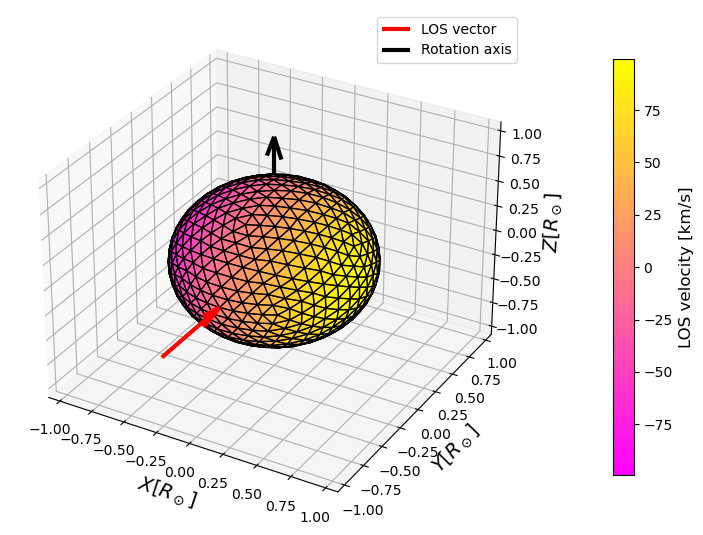

In [4]:
plot_3D(rotated_meshes[0], 'los_velocities', cmap='spring');

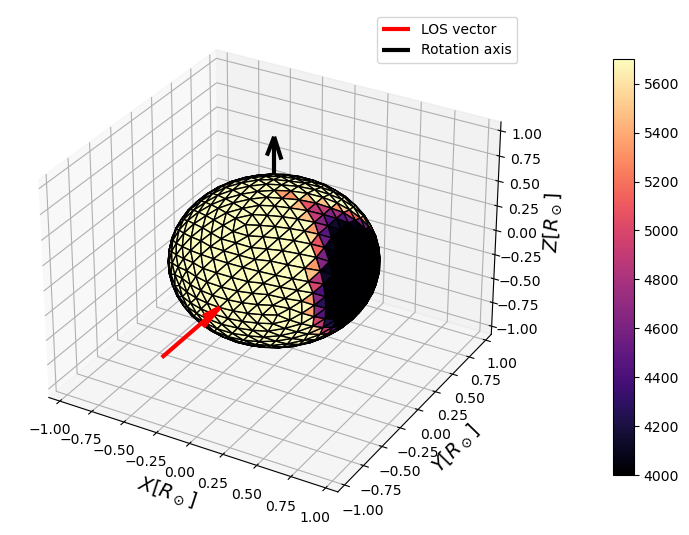

In [8]:
plot_3D(rotated_meshes[0], 0, cmap='magma');

Let's plot several timestamps. (This plot might require some tinkering with the parameters to make it look clear and readable)

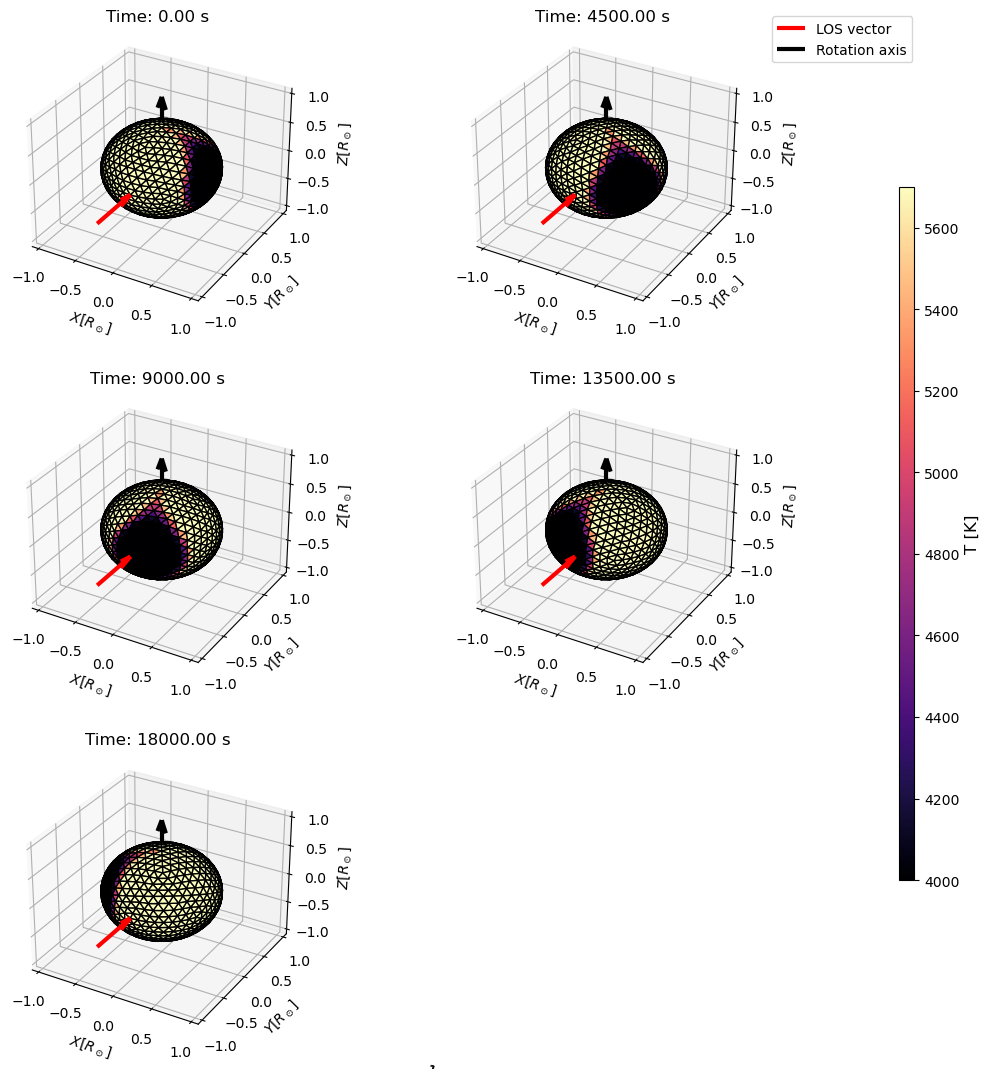

In [7]:
_, plot_axes, cbar_ax = plot_3D_sequence(rotated_meshes, 0, times, property_label='T [K]',
                                         cmap='magma', figsize=(10, 11), timestamp_label='s');

# Spectrum simulation

Let's use the provided blackbody spectrum model to simulate some spectra for our star. We can observe how does the spectrum change for various rotation phases (since the overall temperature changes as well because of the spot)

In [9]:
# Define some wavelengths to evaluate the spectrum at
vws = jnp.linspace(500., 15000., 100)

Text(0, 0.5, 'Intensity [erg/s/$cm^2$/$\\AA$]')

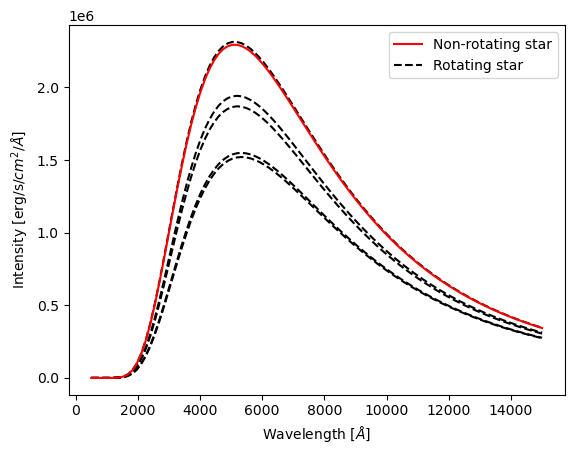

In [18]:
non_rotating_spectrum = simulate_spectrum(blackbody_intensity, spotted_m, jnp.log10(vws))
plt.plot(vws, non_rotating_spectrum[:, 0], color='red', zorder=1, label='Non-rotating star')

for i, _mt in enumerate(rotated_meshes):
    rotating_spectrum = simulate_spectrum(blackbody_intensity, _mt, jnp.log10(vws), 16)
    if i == 0:
        plt.plot(vws, rotating_spectrum[:, 0], color='black', linestyle='--', zorder=0, label='Rotating star')
    else:
        plt.plot(vws, rotating_spectrum[:, 0], color='black', linestyle='--', zorder=0)

plt.legend();
plt.xlabel('Wavelength [$\AA$]');
plt.ylabel('Intensity [erg/s/$cm^2$/$\AA$]')